# 0️⃣ Prerequisite

In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (9,097 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

⚠️⚠️⚠️⚠️⚠️ [런타임] - [런타임 다시 시작] ⚠️⚠️⚠️⚠️⚠️

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Study/Data Science/AI 자연어 처리 전문가 양성 과정 6기/Project 2')

## Import libraries

In [3]:
!pip install datasets
!pip install levenshtein
!pip install torchinfo
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 13.1 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.0/174.0 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-w

In [4]:
import csv
import json
import math
import numpy as np
import pandas as pd
import pickle
import random
import warnings

from collections import defaultdict, OrderedDict
from datasets import Dataset, load_metric
from easydict import EasyDict as edict
from Levenshtein import distance
from pathlib import Path
from tqdm.auto import tqdm

import torch
from torchinfo import summary

from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    default_data_collator,
    EarlyStoppingCallback,
    get_cosine_schedule_with_warmup,
    PreTrainedTokenizerFast,
    Trainer,
    TrainingArguments
)

import matplotlib.pyplot as plt

In [5]:
args = edict({
       'lr': 1e-5,
       'batch_size': {
            'train': 512,
            'dev': 512,
            'test': 512
        },
        'seed': 42,
        'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        'doc_stride': 200, # The authorized overlap between two part of the context when splitting it is needed.
        'epochs': 30,
        'max_length': 1024, # The maximum length of a feature (question and context)
        'model_checkpoint': 'monologg/kobigbird-bert-base',
        'n_best_size': 10,
        'max_answer_length': 5
})
args['accumulation'] = int(args.batch_size.train/16)
args['model_name'] = args.model_checkpoint.split("/")[-1]
args['name'] = f'{args.model_name}_lr{args.lr}_ep{args.epochs}_max{args.max_length}_{random.randrange(0, 1024)}'

In [6]:
def seed_everthing(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everthing(args.seed)

## Loading the model & tokenizer

In [7]:
args.name = 'kobigbird-bert-base_lr1e-05_ep30_max1024_317'
args.model_checkpoint = 'kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue/checkpoint-1593'

In [8]:
config = AutoConfig.from_pretrained(args.model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(args.model_checkpoint)

In [9]:
model = AutoModelForQuestionAnswering.from_pretrained(args.model_checkpoint)
model.to(args.device)

summary(model)

Layer (type:depth-idx)                                            Param #
BigBirdForQuestionAnswering                                       --
├─BigBirdModel: 1-1                                               --
│    └─BigBirdEmbeddings: 2-1                                     --
│    │    └─Embedding: 3-1                                        24,960,000
│    │    └─Embedding: 3-2                                        3,145,728
│    │    └─Embedding: 3-3                                        1,536
│    │    └─LayerNorm: 3-4                                        1,536
│    │    └─Dropout: 3-5                                          --
│    └─BigBirdEncoder: 2-2                                        --
│    │    └─ModuleList: 3-6                                       85,054,464
├─BigBirdForQuestionAnsweringHead: 1-2                            --
│    └─Dropout: 2-3                                               --
│    └─BigBirdIntermediate: 2-4                                   --


In [10]:
config

BigBirdConfig {
  "_name_or_path": "kobigbird-bert-base_lr1e-05_ep30_max1024_317-finetuned-klue/checkpoint-1593",
  "architectures": [
    "BigBirdForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "attention_type": "block_sparse",
  "block_size": 64,
  "bos_token_id": 5,
  "classifier_dropout": null,
  "eos_token_id": 6,
  "gradient_checkpointing": false,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 4096,
  "model_type": "big_bird",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_random_blocks": 3,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "rescale_embeddings": false,
  "sep_token_id": 3,
  "tokenizer_class": "BertTokenizer",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_bias": true,
  "use_cache": true,
  "vocab_size": 32500
}

In [11]:
for ids, sp_tok in sorted(zip(tokenizer.all_special_ids, tokenizer.all_special_tokens)):
  print(ids, sp_tok)

0 [PAD]
1 [UNK]
2 [CLS]
3 [SEP]
4 [MASK]
5 <s>
6 </s>


# 1️⃣ Loading the validation dataset

In [12]:
def read_klue(path):
    path = Path(path)
    with open(path, 'rb') as f:
        data = json.load(f)

    news_categories = []
    guids = []
    contexts = []
    questions = []
    answers = []
    for group in data['data']:
        news_category = group['news_category']
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    news_categories.append(news_category)
                    guids.append(qa["guid"])
                    contexts.append(context)
                    questions.append(question)
                    answers.append({"answer_start": [answer["answer_start"]], "text": [answer["text"]]})

    return news_categories, guids, contexts, questions, answers

In [13]:
file_path = 'input/train.json'

news_categories, guids, contexts, questions, answers = read_klue(file_path)

df = pd.DataFrame(
    list(zip(news_categories, guids , answers, contexts, questions)),
    columns =['news_categories', 'id', 'answers', 'context','question'])
df

,news_categories,id,answers,context,question
0,종합,798db07f0b9046759deed9d4a35ce31e,"{'answer_start': [478], 'text': ['한 달가량']}",올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도...,북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?
1,종합,798db07f0b9046759deed9d4a35ce31e,"{'answer_start': [478], 'text': ['한 달']}",올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도...,북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?
2,경제,67c85e4f86ae43939b807684537c909c,"{'answer_start': [1422], 'text': ['삼보테크놀로지']}",부산시와 (재)부산정보산업진흥원(원장 이인숙)이 ‘2020~2021년 지역SW서비스...,지능형 생산자동화 기반기술을 개발중인 스타트업은?
3,None,d2764543b0a84596942b34071541bed4,"{'answer_start': [107], 'text': ['와쿠이 히데아키']}",시범 경기에서는 16이닝을 던져 15실점을 기록하는 등 성적이 좋지 않았지만 본인으...,개막전에서 3안타 2실점을 기록해서 패한 선수는?
4,생활경제,435aa49b68e8414d8c5e4f8102782b81,"{'answer_start': [408], 'text': ['‘교동반점 짬뽕’']}",유명 맛집 이름을 달고 나온 편의점 자체상표(PB) 라면이 인기를 끌고 있다. ‘검...,컵라면 매출에서 불닭볶음면을 이긴 상품은?
...,...,...,...,...,...
17658,문화/TV,43662d491d8e42b6a92255afd11e0634,"{'answer_start': [170], 'text': ['‘혹성탈출: 반격의 서...",유인원 무리의 리더 시저는 인간 건축가 말콤(제이슨 클락)에게 작별 인사를 한다. ...,혹성탈출의 두 번째 프리퀄의 제목은?
17659,문화/TV,43662d491d8e42b6a92255afd11e0634,"{'answer_start': [171], 'text': ['혹성탈출: 반격의 서막']}",유인원 무리의 리더 시저는 인간 건축가 말콤(제이슨 클락)에게 작별 인사를 한다. ...,혹성탈출의 두 번째 프리퀄의 제목은?
17660,테크,6e16e6a74b40457883771416d3522dc4,"{'answer_start': [197], 'text': ['8시 10분']}",ASUS(에이수스) 그래픽카드 공식수입사 인텍앤컴퍼니(대표 서정욱)는 10월 16일...,인택엔컴퍼니가 실시하는 추첨판매 신청 마감시간은?
17661,생활경제,ea6f9861cab94491b1df195b75e29558,"{'answer_start': [276], 'text': ['28개']}",한국인 최초로 쇼팽국제피아노콩쿠르에서 우승을 차지한 ‘21세 쇼팽’ 조성진 마케팅이...,유니버셜뮤직과 협력하여 만든 메가기프트를 살 수 있는 업체의 매장 수는?


In [14]:
df_duplicated = df

In [15]:
df = (
    df.assign(answer_length=df['answers'].map(lambda x: len(x['text'][0])))
    .sort_values('answer_length')
    .drop_duplicates(subset=['id'], keep="first")
).drop('answer_length', axis=1).sort_index().reset_index(drop=True)
df

,news_categories,id,answers,context,question
0,종합,798db07f0b9046759deed9d4a35ce31e,"{'answer_start': [478], 'text': ['한 달']}",올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도...,북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?
1,경제,67c85e4f86ae43939b807684537c909c,"{'answer_start': [1422], 'text': ['삼보테크놀로지']}",부산시와 (재)부산정보산업진흥원(원장 이인숙)이 ‘2020~2021년 지역SW서비스...,지능형 생산자동화 기반기술을 개발중인 스타트업은?
2,None,d2764543b0a84596942b34071541bed4,"{'answer_start': [107], 'text': ['와쿠이 히데아키']}",시범 경기에서는 16이닝을 던져 15실점을 기록하는 등 성적이 좋지 않았지만 본인으...,개막전에서 3안타 2실점을 기록해서 패한 선수는?
3,생활경제,435aa49b68e8414d8c5e4f8102782b81,"{'answer_start': [409], 'text': ['교동반점 짬뽕']}",유명 맛집 이름을 달고 나온 편의점 자체상표(PB) 라면이 인기를 끌고 있다. ‘검...,컵라면 매출에서 불닭볶음면을 이긴 상품은?
4,생활경제,4fa200ce1e3a4a279c43c1de40fb27b3,"{'answer_start': [617], 'text': ['불닭볶음면']}",유명 맛집 이름을 달고 나온 편의점 자체상표(PB) 라면이 인기를 끌고 있다. ‘검...,재작년 세븐일레븐 컵라면 중 제일 많이 팔린 제품은?
...,...,...,...,...,...
12032,중기 의료,b04093b7ee9449d98215c467526cecac,"{'answer_start': [229], 'text': ['전문 경영인 체제']}",“오너 경영은 중견기업이 글로벌 전문기업이나 대기업으로 성장하는 밑거름이 될 것입니...,이동기 학회장은 오너 경영을 무엇과 비교했는가?
12033,산업,ab75ad70e2804f5abeafebdd23a0deaa,"{'answer_start': [134], 'text': ['롯데백화점 잠실점']}",홈 뷰티 디바이스 브랜드 ‘엘리닉(L.linic)’이 고객 감사의 달을 맞아 전국 ...,팝업스토어 앵콜 행사를 가장 먼저 시작하는 곳은 어디인가?
12034,문화/TV,43662d491d8e42b6a92255afd11e0634,"{'answer_start': [171], 'text': ['혹성탈출: 반격의 서막']}",유인원 무리의 리더 시저는 인간 건축가 말콤(제이슨 클락)에게 작별 인사를 한다. ...,혹성탈출의 두 번째 프리퀄의 제목은?
12035,테크,6e16e6a74b40457883771416d3522dc4,"{'answer_start': [197], 'text': ['8시 10분']}",ASUS(에이수스) 그래픽카드 공식수입사 인텍앤컴퍼니(대표 서정욱)는 10월 16일...,인택엔컴퍼니가 실시하는 추첨판매 신청 마감시간은?


In [16]:
train_df = df.sample(frac=0.8, random_state=args.seed)
dev_df = df.drop(train_df.index)
print(f'{df.shape[0]} =====> train: {train_df.shape[0]} + dev: {dev_df.shape[0]}')

12037 =====> train: 9630 + dev: 2407


In [17]:
train_df = dev_df.reset_index(drop=True)
dev_df = dev_df.reset_index(drop=True)

dev_df_nc = dev_df.drop(['news_categories'], axis=1)

In [18]:
dev_dataset = Dataset.from_pandas(dev_df_nc)

print("Number of Dev Samples:", len(dev_dataset))
print(dev_dataset[0])

Number of Dev Samples: 2407
{'id': '67c85e4f86ae43939b807684537c909c', 'answers': {'answer_start': [1422], 'text': ['삼보테크놀로지']}, 'context': '부산시와 (재)부산정보산업진흥원(원장 이인숙)이 ‘2020~2021년 지역SW서비스사업화 지원사업’ 공모사업에 4개 과제가 선정되어 본격적인 사업 착수에 나선다. 과학기술정보통신부가 주관하는 ‘지역SW서비스사업화 지원사업’은 강소SW기업 및 초기 스타트업의 SW서비스 사업화 지원과 신시장 진출 지원을 통해 기업 경쟁력 강화와 지역경제 활성화를 도모하는 사업이다. 올해부터 2개년으로 진행되며, 국비와 시비, 민자 등 2년간 약 37억원의 예산이 투입된다. 앞서 진흥원은 부산의 미래 먹거리산업인 스마트해양, 지능형기계, 지능정보서비스 분야로 사전 수요조사를 진행했고, 평가를 통해 선정된 5개 과제를 공모사업에 신청했다. 그 결과 부산의 4개 과제가 최종 선정되는 쾌거를 거뒀다. 당 사업은 전국 진흥기관을 대상으로 공모를 시작해, 총 17개 지역에서 42개 과제가 선정되었으며, 4개 과제가 선정된 곳은 부산과 강원지역 뿐이다. 금번 선정된 과제들은 ‘인공지능융합센서와 서보 이송 로봇을 이용한 전단보강재의 자동용접시스템 개발’ 등 총 4개 과제다. 부산시가 지원하고, 부산정보산업진흥원과 지역기업, 대학, 연구소 등이 컨소시엄을 구성하여 기술개발 및 사업화 지원을 추진한다. 2개의 Track으로 구분되는 이번사업은 Track 1(SW중소기업)에서 ㈜에이아이플랫폼, 엔컴(주), Track 2(스타트업)에서는 ㈜토즈, 삼보테크놀로지를 지원한다. ○ ‘Track 1‘의 (주)에이아이플랫폼이 주관기업으로 진행하는 <인공지능 기반 망막 내 아밀로이드 플라크 영상 분석을 통한 치매조기진단 플랫폼 상용화>는 치매 확진의 원인이 되는 중요 단백질(아밀로이드 플라크)을 자체개발 관측장비로 진단한다. 이를 통해 치매를 조기 발견하여, 각종

# 2️⃣ Evaluation

In [19]:
pad_on_right = tokenizer.padding_side == "right"

In [20]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=args.max_length,
        stride=args.doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [21]:
validation_features = dev_dataset.map(
    prepare_validation_features,
    batched=True,
    remove_columns=dev_dataset.column_names
)

  0%|          | 0/3 [00:00<?, ?ba/s]

## Postprocessing (1)

In [22]:
with open(f'output/raw_predictions-{args.name}-finetuned-klue.pkl', 'rb') as fd:
    raw_predictions = pickle.load(fd)

In [23]:
def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 10, max_answer_length = 10):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions

In [24]:
squad_v2 = True

In [25]:
metric = load_metric("squad_v2" if squad_v2 else "squad")

<ipython-input-25-69495f532713>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2" if squad_v2 else "squad")


In [26]:
def calculate_distances(predictions):
    first_distances = []
    second_distances = []

    for sample in predictions:
        id = sample['id']
        predicted = sample['prediction_text']
        mask = df_duplicated.id == id
        answers = df_duplicated.loc[mask, 'answers'].map(lambda x: x['text'][0])

        ds = []
        for reference in answers:
            ds.append(distance(predicted, reference))
        
        first_distances.append(ds[0])
        if len(ds) > 1:
            second_distances.append(ds[1])
        else:
            second_distances.append(ds[0])
    
    return first_distances, second_distances

In [27]:
def evaluate(raw_predictions, n_best_size, max_answer_length):
    final_predictions = postprocess_qa_predictions(dev_dataset, validation_features, raw_predictions.predictions, n_best_size=n_best_size, max_answer_length=max_answer_length)
    
    if squad_v2:
        formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
    else:
        formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
    references = [{"id": ex["id"], "answers": ex["answers"]} for ex in dev_dataset]
    results = metric.compute(predictions=formatted_predictions, references=references)

    predictions_text = pd.DataFrame.from_dict(formatted_predictions)['prediction_text']
    references_text = pd.DataFrame.from_dict(references)['answers'].map(lambda x: x['text'][0])

    first_distances, second_distances = calculate_distances(formatted_predictions)

    return np.mean(first_distances), np.mean(second_distances), results['exact'], results['f1']

In [28]:
n_best_sizes = []
max_answer_lengths = []
d1s = []
d2s = []
ems = []
f1s = []

for n_best_size in [10, 20, 30]:
    for max_answer_length in [3, 5, 7, 10, 20]:
        d1, d2, em, f1 = evaluate(raw_predictions, n_best_size, max_answer_length)
        n_best_sizes.append(n_best_size)
        max_answer_lengths.append(max_answer_length)
        d1s.append(d1)
        d2s.append(d2)
        ems.append(em)
        f1s.append(f1)

evaluation_results = pd.DataFrame(data={
    'n_best_size': n_best_sizes,
    'max_answer_length': max_answer_lengths,
    'first_distance': d1s,
    'second_distance': d2s,
    'exact_match': ems,
    'f1': f1s})
evaluation_results

Post-processing 2407 example predictions split into 2442 features.


  0%|          | 0/2407 [00:00<?, ?it/s]

Post-processing 2407 example predictions split into 2442 features.


  0%|          | 0/2407 [00:00<?, ?it/s]

Post-processing 2407 example predictions split into 2442 features.


  0%|          | 0/2407 [00:00<?, ?it/s]

Post-processing 2407 example predictions split into 2442 features.


  0%|          | 0/2407 [00:00<?, ?it/s]

Post-processing 2407 example predictions split into 2442 features.


  0%|          | 0/2407 [00:00<?, ?it/s]

Post-processing 2407 example predictions split into 2442 features.


  0%|          | 0/2407 [00:00<?, ?it/s]

Post-processing 2407 example predictions split into 2442 features.


  0%|          | 0/2407 [00:00<?, ?it/s]

Post-processing 2407 example predictions split into 2442 features.


  0%|          | 0/2407 [00:00<?, ?it/s]

Post-processing 2407 example predictions split into 2442 features.


  0%|          | 0/2407 [00:00<?, ?it/s]

Post-processing 2407 example predictions split into 2442 features.


  0%|          | 0/2407 [00:00<?, ?it/s]

Post-processing 2407 example predictions split into 2442 features.


  0%|          | 0/2407 [00:00<?, ?it/s]

Post-processing 2407 example predictions split into 2442 features.


  0%|          | 0/2407 [00:00<?, ?it/s]

Post-processing 2407 example predictions split into 2442 features.


  0%|          | 0/2407 [00:00<?, ?it/s]

Post-processing 2407 example predictions split into 2442 features.


  0%|          | 0/2407 [00:00<?, ?it/s]

Post-processing 2407 example predictions split into 2442 features.


  0%|          | 0/2407 [00:00<?, ?it/s]

,n_best_size,max_answer_length,first_distance,second_distance,exact_match,f1
0,10,3,3.051516,2.449938,55.670960,63.121896
1,10,5,2.435812,1.920233,64.852514,70.811976
2,10,7,2.286248,1.812630,67.054425,72.611269
3,10,10,2.222268,1.795596,67.552971,72.937127
4,10,20,2.386373,1.962609,67.095970,72.734396
5,20,3,3.044454,2.441629,55.629414,63.105080
6,20,5,2.432489,1.916494,64.852514,70.843630
7,20,7,2.286248,1.812630,67.054425,72.611269
8,20,10,2.222268,1.795596,67.552971,72.937127
9,20,20,2.386373,1.962609,67.095970,72.734396


In [29]:
args.n_best_size = 10
args.max_answer_length = 10

final_predictions = postprocess_qa_predictions(dev_dataset, validation_features, raw_predictions.predictions, n_best_size = args.n_best_size, max_answer_length = args.max_answer_length)

Post-processing 2407 example predictions split into 2442 features.


  0%|          | 0/2407 [00:00<?, ?it/s]

In [30]:
if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in dev_dataset]
metric.compute(predictions=formatted_predictions, references=references)

{'exact': 67.55297050270046,
 'f1': 72.93712656294844,
 'total': 2407,
 'HasAns_exact': 67.55297050270046,
 'HasAns_f1': 72.93712656294844,
 'HasAns_total': 2407,
 'best_exact': 67.55297050270046,
 'best_exact_thresh': 0.0,
 'best_f1': 72.93712656294844,
 'best_f1_thresh': 0.0}

In [31]:
predictions_text = pd.DataFrame.from_dict(formatted_predictions)['prediction_text']
references_text = pd.DataFrame.from_dict(references)['answers'].map(lambda x: x['text'][0])

first_distances, second_distances = calculate_distances(formatted_predictions)

print(np.mean(first_distances), np.mean(second_distances))

2.222268383880349 1.7955961778147072


## Error analysis

In [38]:
dev_df['predictions_text'] = list(predictions_text)
dev_df['first_distance'] = first_distances
dev_df['second_distance'] = second_distances

In [39]:
def draw_pie(df, title):
    ratio = df['news_categories'].value_counts().values.tolist()
    labels = df['news_categories'].value_counts().index.tolist()

    plt.figure(figsize=(15, 15))
    plt.rc('font', family='NanumBarunGothic', size=15)
    plt.pie(ratio, labels=labels, autopct='%.1f%%')
    plt.title(title)
    plt.show()

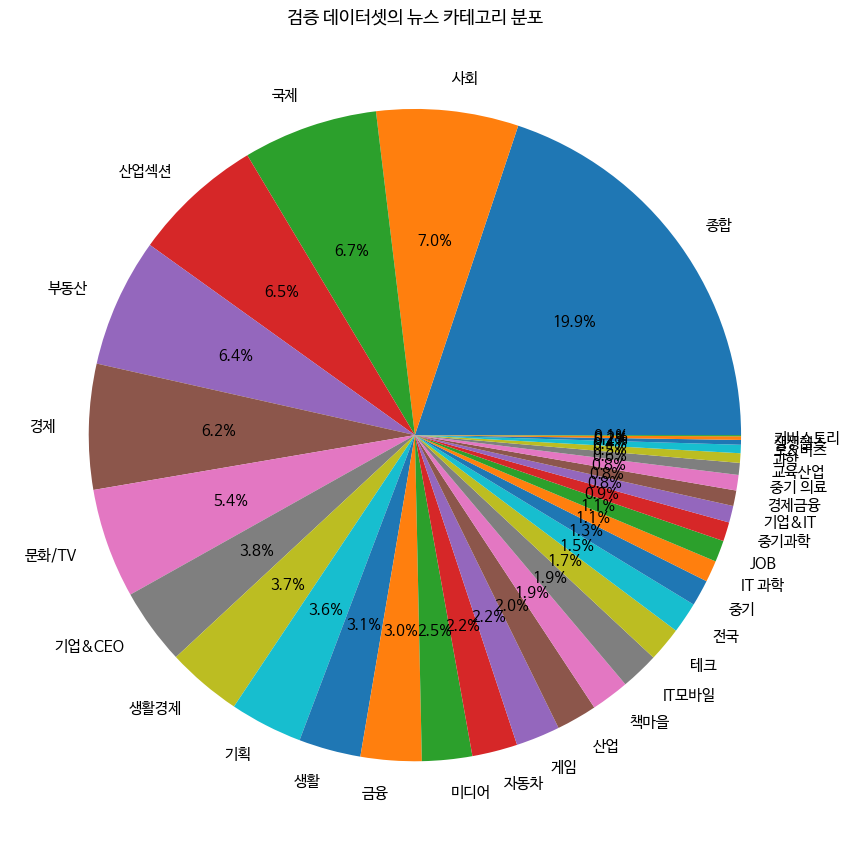

In [40]:
draw_pie(dev_df, title='검증 데이터셋의 뉴스 카테고리 분포')

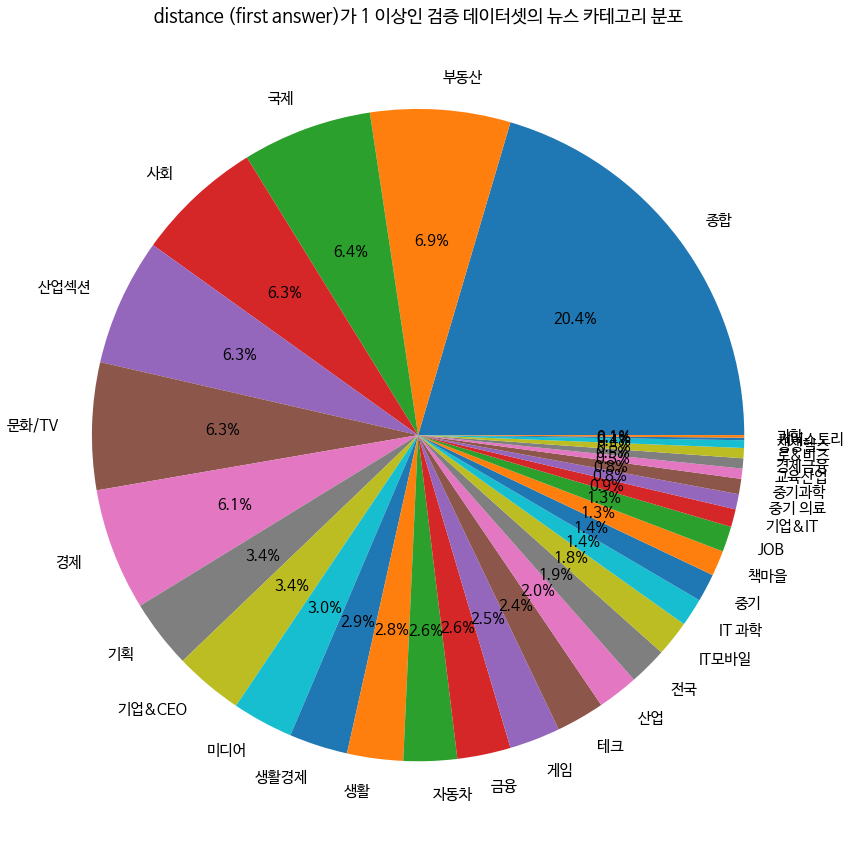

In [41]:
mask = dev_df.first_distance >= 1
dev_df_error = dev_df.loc[mask, :]

draw_pie(dev_df_error, title='distance (first answer)가 1 이상인 검증 데이터셋의 뉴스 카테고리 분포')

count    2407.000000
mean        2.222268
std         4.456592
min         0.000000
25%         0.000000
50%         0.000000
75%         3.000000
max        69.000000
Name: first_distance, dtype: float64


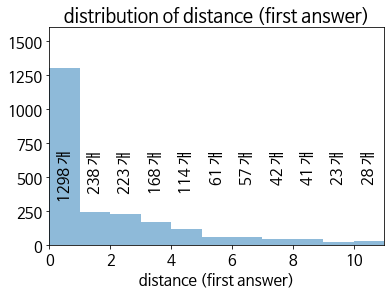

7.5


In [78]:
mask = dev_df.first_distance >= 0
dev_df_error = dev_df.loc[mask, :]
weight = dev_df_error.first_distance
print(weight.describe())
plt.hist(weight, bins=max(weight), alpha=0.5, histtype='bar')

plt.rc('font', family='NanumBarunGothic', size=15)
plt.title('distribution of distance (first answer)')
plt.xlabel('distance (first answer)')
plt.xlim([0, 11])
plt.ylim([0, 1600])
for i in range(0, 11):
    cnt = dev_df.loc[dev_df.first_distance == i, :].shape[0]
    plt.text(i+0.5, 700, f'{cnt} 개', rotation=90, verticalalignment='top', horizontalalignment='center')
plt.show()

q3 = weight.quantile(0.75)
q1 = weight.quantile(0.25)
iqr = q3 - q1

print(q3 + 1.5 * iqr)

count    2407.000000
mean        1.795596
std         3.984458
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        69.000000
Name: second_distance, dtype: float64


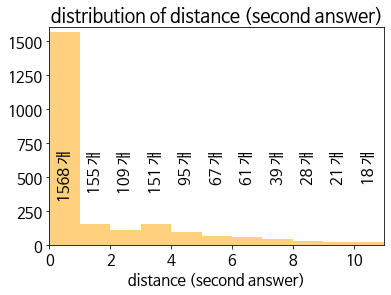

5.0


In [77]:
mask = dev_df.second_distance >= 0
dev_df_error = dev_df.loc[mask, :]
weight = dev_df_error.second_distance
print(weight.describe())
plt.hist(weight, bins=max(weight), alpha=0.5, histtype='bar', color='orange')

plt.rc('font', family='NanumBarunGothic', size=15)
plt.title('distribution of distance (second answer)')
plt.xlabel('distance (second answer)')
plt.xlim([0, 11])
plt.ylim([0, 1600])
for i in range(0, 11):
    cnt = dev_df.loc[dev_df.second_distance == i, :].shape[0]
    plt.text(i+0.5, 700, f'{cnt} 개', rotation=90, verticalalignment='top', horizontalalignment='center')
plt.show()

q3 = weight.quantile(0.75)
q1 = weight.quantile(0.25)
iqr = q3 - q1

print(q3 + 1.5 * iqr)

In [48]:
mask = dev_df.first_distance == 1
dev_df_error = dev_df.loc[mask, :]

dev_df_error[['answers', 'predictions_text']]

,answers,predictions_text
19,"{'answer_start': [214], 'text': ['11']}",11
33,"{'answer_start': [87], 'text': ['1992']}",1992
36,"{'answer_start': [417], 'text': ['5점']}",5
44,"{'answer_start': [194], 'text': ['DEC']}",DEC
50,"{'answer_start': [1361], 'text': ['10']}",10
...,...,...
2345,"{'answer_start': [1306], 'text': ['4,500원']}","84,500원"
2346,"{'answer_start': [834], 'text': ['143']}",143
2358,"{'answer_start': [142], 'text': ['336']}",336
2385,"{'answer_start': [666], 'text': ['1984년']}",1984


## Postprocessing (2) - 형태소 분석

In [70]:
def new_postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 10, max_answer_length = 10):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char + 1] # 🌟 end_char + 1
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions

In [71]:
final_predictions = new_postprocess_qa_predictions(dev_dataset, validation_features, raw_predictions.predictions, n_best_size = args.n_best_size, max_answer_length = args.max_answer_length)

Post-processing 2407 example predictions split into 2442 features.


  0%|          | 0/2407 [00:00<?, ?it/s]

In [72]:
if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]

predictions_text = pd.DataFrame.from_dict(formatted_predictions)['prediction_text']

In [73]:
import os
os.chdir('/content')

!git clone https://github.com/kakao/khaiii.git
!pip install cmake
!mkdir build
!cd build && cmake /content/khaiii
!cd /content/build/ && make all
!cd /content/build/ && make resource
!cd /content/build && make install
!cd /content/build && make package_python
!pip install /content/build/package_python

os.chdir('/content/drive/MyDrive/Study/Data Science/AI 자연어 처리 전문가 양성 과정 6기/Project 2')

from khaiii import KhaiiiApi

khaiiApi = KhaiiiApi()

fatal: destination path 'khaiii' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘build’: File exists
-- [khaiii] fused multiply add option enabled
-- [hunter] Calculating Toolchain-SHA1
-- [hunter] Calculating Config-SHA1
-- [hunter] HUNTER_ROOT: /root/.hunter
-- [hunter] [ Hunter-ID: 70287b1 | Toolchain-ID: 02ccb06 | Config-ID: dffbc08 ]
-- [hunter] BOOST_ROOT: /root/.hunter/_Base/70287b1/02ccb06/dffbc08/Install (ver.: 1.68.0-p1)
-- Boost version: 1.68.0
-- [hunter] CXXOPTS_ROOT: /root/.hunter/_Base/70287b1/02ccb06/dffbc08/Install (ver.: 2.1.1-pre)
-- [hunter] EIGEN_ROOT: /root/.hunter/_Base/70287b1/02ccb06/dffbc08/Install (ver.: 3.3.5)
-- [hunter] FMT_ROOT: /root/.hunter/_Base/70287b1/02ccb06/dffbc08/Install (ver.: 4.1.0)
-- [hunter] GTEST_ROOT: /root/.hunter/_Base/70287b1/02ccb06/dffbc08/Install (ver.: 1.8.0-hunter-p11)
-- [hunter] NLOHMANN_JSON_ROOT: /roo

In [74]:
new_predictions_text = []

for i, text in enumerate(predictions_text):
    if not text:
        new_predictions_text.append("")
        continue
    analyzed = khaiiApi.analyze(text)

    results = []
    for word in analyzed:
        for morph in word.morphs:
    	    results.append((morph.lex, morph.tag))
    
    lex = results[-1][0]
    tag = results[-1][1]

    if tag in ['NNB', 'SW']:
        new_text = text.strip()
        print(lex, tag, text, new_text, sep='-')
    elif 'JK' in tag:
        new_text = text.strip()[:-len(lex)]
        print(lex, tag, text, new_text, sep='-')
    else:
        new_text = text[:-1]

    new_predictions_text.append(new_text.strip())

dev_df['new_predictions_text'] = new_predictions_text

를-JKO-토즈, 삼보테크놀로지를-토즈, 삼보테크놀로지
일-NNB-11월 7일 -11월 7일
이-JKS-키쿠유족이-키쿠유족
가-JKS-기원전 4세기가-기원전 4세기
월-NNB-11월-11월
을-JKO-쏘울을-쏘울
㎡-SW-3만4286㎡-3만4286㎡
을-JKO-감정을-감정
의-JKG-동아일보의-동아일보
에-JKB-세계 체스 챔피언십에-세계 체스 챔피언십
년-NNB-1992년-1992년
%-SW-1.8%-1.8%
점-NNB-5점-5점
을-JKO-경원대군을-경원대군
에-JKB-62만 8천원에-62만 8천원
년-NNB-60년-60년
이-JKS-조선공산당이-조선공산당
%-SW-10%-10%
일-NNB-19일 -19일
야-JKV-인종주의야-인종주의
에-JKB-물산장려운동에-물산장려운동
로-JKB-상하이로-상하이
로-JKB-상하이로-상하이
가-JKS-컴퓨터가-컴퓨터
가-JKS-건과류가-건과류
에-JKB-2004년의 국방부 보고서에-2004년의 국방부 보고서
을-JKO-소련군을-소련군
를-JKO-조선혁명간부학교를-조선혁명간부학교
㎏-SW-40㎏ -40㎏
를-JKO-트라키아일리리아어파를-트라키아일리리아어파
로-JKB-결막하 출혈로-결막하 출혈
의-JKG-불가리아의-불가리아
에-JKB-하이노하라 전투에-하이노하라 전투
을-JKO-상대성이론을-상대성이론
의-JKG-CJ제일제당의-CJ제일제당
%-SW-30% -30%
년-NNB-1956년-1956년
세-NNB-60세 -60세
개-NNB-17개-17개
의-JKG-순치제의-순치제
년-NNB-1688년-1688년
로-JKB-심장마비로-심장마비
년-NNB-1968년 -1968년
에-JKB-고금대교에-고금대교
년-NNB-2002년-2002년
년-NNB-1726년-1726년
년-NNB-1951년-1951년
가-JKS-감지기가-감지기
가-JKS-스티브 잡스가-스티브 잡스
의-JKG-보니파시오의-보니파시오
원-NNB-2조153억원 -2조153억원
의-JKG-고구려의-고구려
년-NNB-2016년-2016년
로-JKB-Delay 1968로-Dela

In [75]:
def new_calculate_distances(predictions, predictions_text):
    first_distances = []
    second_distances = []

    for index, sample in predictions:
        id = sample['id']
        predicted = sample[predictions_text]
        mask = df_duplicated.id == id
        answers = df_duplicated.loc[mask, 'answers'].map(lambda x: x['text'][0])

        ds = []
        for reference in answers:
            ds.append(distance(predicted, reference))
        
        first_distances.append(ds[0])
        if len(ds) > 1:
            second_distances.append(ds[1])
        else:
            second_distances.append(ds[0])
    
    return first_distances, second_distances

In [111]:
new_first_distances, new_second_distances = new_calculate_distances(dev_df[['id', 'new_predictions_text']].iterrows(), 'new_predictions_text')

print(np.mean(new_first_distances), np.mean(new_second_distances))

2.136684669713336 1.8404653095139178


In [113]:
dev_df['new_first_distance'] = new_first_distances
dev_df['new_second_distance'] = new_second_distances

In [97]:
mask = dev_df['predictions_text'] != dev_df['new_predictions_text']
dev_df.loc[mask, :][['predictions_text', 'new_predictions_text']]

,predictions_text,new_predictions_text
19,11,11월
22,3만4286,3만4286㎡
33,1992,1992년
34,1.8,1.8%
36,5,5점
...,...,...
2376,1922,1922년
2385,1984,1984년
2388,1400여명이 지원해 500,1400여명이 지원해 500명
2400,25.8,25.8%


In [ ]:
distance_threshold = 1


plt.xlabel('first distance')
plt.title('first distance의 분포 (1 이상)')
plt.show()

q3 = weight.quantile(0.75)
q1 = weight.quantile(0.25)
iqr = q3 - q1

print(q3 + 1.5 * iqr)

count    2407.000000
mean        2.136685
std         4.477246
min         0.000000
25%         0.000000
50%         0.000000
75%         3.000000
max        69.000000
Name: new_first_distance, dtype: float64


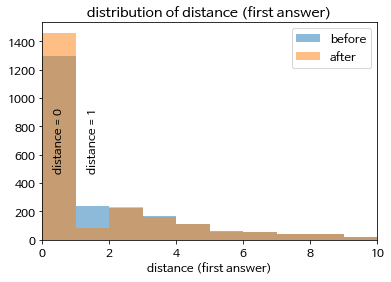

7.5


In [126]:
distance_threshold = 0

mask = dev_df.first_distance >= distance_threshold
dev_df_error = dev_df.loc[mask, :]
weight = dev_df_error.first_distance
plt.hist(weight, bins=max(weight), alpha = 0.5, histtype='bar', label='before')

mask = dev_df.new_first_distance >= distance_threshold
dev_df_error = dev_df.loc[mask, :]
weight = dev_df_error.new_first_distance
print(weight.describe())
plt.hist(weight, bins=max(weight), alpha = 0.5, histtype='bar', label='after')

plt.rc('font', family='NanumBarunGothic', size=12)
plt.title('distribution of distance (first answer)')
plt.xlabel('distance (first answer)')
plt.xlim([0, 10])
plt.legend()
plt.text(0.5, 700, 'distance = 0', rotation=90, verticalalignment='center', horizontalalignment='center')
plt.text(1.5, 700, 'distance = 1', rotation=90, verticalalignment='center' , horizontalalignment='center')
plt.show()

q3 = weight.quantile(0.75)
q1 = weight.quantile(0.25)
iqr = q3 - q1

print(q3 + 1.5 * iqr)

# 3️⃣ Submission

In [77]:
def read_test(path):
    path = Path(path)
    with open(path, 'rb') as f:
        data = json.load(f)

    ids = []
    contexts = []
    questions = []
    answers = []
    for group in data['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                id = qa["guid"]
                question = qa['question']
                answer = qa['answers']
                contexts.append(context)
                questions.append(question)
                answers.append(answer)
                ids.append(id)

    return ids, contexts, questions, answers

In [78]:
file_path =  'input/test.json'

ids, contexts, questions, answers = read_test(file_path)

test_df = pd.DataFrame(
    list(zip(ids , answers, contexts, questions)),
    columns =['id','answers', 'context','question'])
test_df

,id,answers,context,question
0,d14cb73158624cf094c546d856fd3c80,None,BMW 코리아(대표 한상윤)는 창립 25주년을 기념하는 ‘BMW 코리아 25주년 에...,말라카이트에서 나온 색깔을 사용한 에디션은?
1,906631384e91493ebe1c7f34aea6f241,None,프랑스 남부 알프스에 떨어져 150명의 사망자를 낸 저먼윙스 여객기는 부조종사가 의...,사고 비행기의 목적지는?
2,35e61dcb479643448a2cb7d326ae50a6,None,가장 일하고 싶은 회사로 미국 컨설팅 업체인 베인&컴퍼니가 선정됐다. 트위터와 링크...,2014년 일하고 싶은 50대 회사 중에서 5위로 선정된 기업은?
3,075e761b370040cb9041eecd39afc27c,None,가장 일하고 싶은 회사로 미국 컨설팅 업체인 베인&컴퍼니가 선정됐다. 트위터와 링크...,포브스의 2014년 일하고 싶은 50대 회사 조사에서 5위를 한 기업은?
4,e67ed38f3dd944be94d5b4c53731f334,None,성악가로서 한창 전성기를 구가하던 1987년 호세 카레라스는 청천벽력같은 소식을 듣...,호세 카레라스가 재단의 도움을 받아 병을 치료한 병원의 소재지는?
...,...,...,...,...
4003,05fcb8054dc44dab8683579c2cf5e465,None,일본 도쿄지점 130억원대 부당대출 혐의로 금융감독원의 검사를 받고 있는 기업은행이...,도쿄지점의 현재 개인 신용대출 한도는?
4004,cc7f826b66724ce9b39e3a974ca15661,None,한국전쟁 당시 언니인 수지는 여동생 오목이를 고의로 방치했다. 수지는 신경쓰지 않고...,오목이 수지에게 청탁한 남편의 일자리 장소는?
4005,3282034aa41e4fab980851ffd4a868dd,None,세계 컨테이너선 운임지수가 사상 최저 수준으로 떨어지면서 해운업계에 비상이 걸렸다....,컨테이너선 평균 운임이 15%정도 낮아진 노선은?
4006,0a73550b36df4baf82ac2f98619d22e7,None,"서울교육청이 8일부터 10일까지 강남구, 서초구 지역에 있는 유치원, 초등학교의 전...",강남지역에 사는 학생들은 며칠 동안 학교를 안가나?


In [79]:
test_dataset = Dataset.from_pandas(test_df)
print("Number of Test Samples:", len(test_dataset))

Number of Test Samples: 4008


In [80]:
test_features = test_dataset.map(
    prepare_validation_features,
    batched=True,
    remove_columns=test_dataset.column_names
)

  0%|          | 0/5 [00:00<?, ?ba/s]

In [81]:
with open(f'output/test_raw_predictions-{args.name}-finetuned-klue.pkl', 'rb') as fd:
    test_raw_predictions = pickle.load(fd)

In [100]:
print(args.n_best_size)
print(args.max_answer_length)
print(squad_v2)

test_final_predictions = postprocess_qa_predictions(test_dataset, test_features, test_raw_predictions.predictions, n_best_size = args.n_best_size, max_answer_length = args.max_answer_length)

10
10
True
Post-processing 4008 example predictions split into 4073 features.


  0%|          | 0/4008 [00:00<?, ?it/s]

In [101]:
test_formatted_predictions = [{"Id": k, "Predicted": v} for k, v in test_final_predictions.items()]

In [102]:
df = pd.DataFrame.from_dict(test_formatted_predictions)
df

,Id,Predicted
0,d14cb73158624cf094c546d856fd3c80,뉴 740Li
1,906631384e91493ebe1c7f34aea6f241,독일 뒤셀도르프로
2,35e61dcb479643448a2cb7d326ae50a6,링크트인과 페이스북
3,075e761b370040cb9041eecd39afc27c,링크트인과 페이스북
4,e67ed38f3dd944be94d5b4c53731f334,마드리드
...,...,...
4003,05fcb8054dc44dab8683579c2cf5e465,400만엔에서 200만엔
4004,cc7f826b66724ce9b39e3a974ca15661,중동
4005,3282034aa41e4fab980851ffd4a868dd,아시아~유럽
4006,0a73550b36df4baf82ac2f98619d22e7,10일


In [103]:
df.to_csv(f'output/submission-{args.name}.csv', index=False, header=True)

In [104]:
def postprocess_test(test_dataset, test_features, raw_predictions):
    final_predictions = new_postprocess_qa_predictions(test_dataset, test_features, raw_predictions.predictions, n_best_size = args.n_best_size, max_answer_length = args.max_answer_length)
    
    if squad_v2:
        formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
    else:
        formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
    predictions_text = pd.DataFrame.from_dict(formatted_predictions)['prediction_text']
    
    new_predictions_text = []
    for i, text in enumerate(predictions_text):
        if not text:
            new_predictions_text.append("")
            continue
        analyzed = khaiiApi.analyze(text)
        results = []
        for word in analyzed:
            for morph in word.morphs:
                results.append((morph.lex, morph.tag)) 
        lex = results[-1][0]
        tag = results[-1][1]
        if tag in ['NNB', 'SW']:
            new_text = text.strip()
            print(lex, tag, text, new_text, sep='-')
        elif 'JK' in tag:
            new_text = text.strip()[:-len(lex)]
            print(lex, tag, text, new_text, sep='-')
        else:
            new_text = text[:-1]
        new_predictions_text.append(new_text.strip())

    return new_predictions_text

In [105]:
print(args.n_best_size)
print(args.max_answer_length)
print(squad_v2)

df['Predicted'] = postprocess_test(test_dataset, test_features, test_raw_predictions)

10
10
True
Post-processing 4008 example predictions split into 4073 features.


  0%|          | 0/4008 [00:00<?, ?it/s]

로-JKB-독일 뒤셀도르프로 -독일 뒤셀도르프
이-JKS-링크트인과 페이스북이-링크트인과 페이스북
이-JKS-링크트인과 페이스북이-링크트인과 페이스북
에-JKB-마드리드에-마드리드
원-NNB-5조원 -5조원
시-NNB-중합시-중합시
로-JKB-노르웨이로-노르웨이
개-NNB-22개 -22개
로-JKB-79달러로-79달러
의-JKG-존 위클리프의-존 위클리프
가-JKS-지기스문트가-지기스문트
를-JKO-서울대 음대를-서울대 음대
의-JKG-독일의-독일
을-JKO-보석을-보석
에-JKB-귈리엘모 왕에-귈리엘모 왕
를-JKO-부레를-부레
를-JKO-이산화탄소를-이산화탄소
가-JKS-척추가-척추
이-JKS-분류학적 접근이-분류학적 접근
을-JKO-공직자윤리법을-공직자윤리법
일-NNB-9월22일 -9월22일
에-JKB-소련 헌법에-소련 헌법
의-JKG-인도의-인도
에-JKB-Uraniborg에-Uraniborg
로-JKB-프라하로-프라하
편-NNB-577편으로 지난해 같은 기간의 440편-577편으로 지난해 같은 기간의 440편
이-JKS-각막 궤양이 -각막 궤양
의-JKG-셀레우키아크테시폰의-셀레우키아크테시폰
로-JKB-개혁파로-개혁파
을-JKO-아드레날린을-아드레날린
일-NNB-6일 -6일
를-JKO-레이다를-레이다
를-JKO-도로스를-도로스
가-JKS-쿠니스가-쿠니스
이-JKS-코오롱워터앤솔루션이-코오롱워터앤솔루션
의-JKG-이디야의-이디야
개-NNB-8개-8개
원-NNB-10억원 -10억원
년-NNB-2004년-2004년
년-NNB-15년-15년
개-NNB-41개 -41개
으-JKB-핵으-핵
이-JKS-데프레닐이-데프레닐
이-JKS-미용이-미용
에-JKB-쿠에농강에-쿠에농강
을-JKO-등산 스틱을-등산 스틱
을-JKO-70선을-70선
분-NNB-13시간 35분 -13시간 35분
을-JKO-3000억원을-3000억원
이-JKS-70만원이-70만원
이-JKS-이준용이-이준용
을-JKO-3.1 만세 운동을-3.1 만세 운동
를-JKO-박영효를-박영효
로-JKB-강원도관

In [106]:
df

,Id,Predicted
0,d14cb73158624cf094c546d856fd3c80,뉴 740Li
1,906631384e91493ebe1c7f34aea6f241,독일 뒤셀도르프
2,35e61dcb479643448a2cb7d326ae50a6,링크트인과 페이스북
3,075e761b370040cb9041eecd39afc27c,링크트인과 페이스북
4,e67ed38f3dd944be94d5b4c53731f334,마드리드
...,...,...
4003,05fcb8054dc44dab8683579c2cf5e465,400만엔에서 200만엔
4004,cc7f826b66724ce9b39e3a974ca15661,중동
4005,3282034aa41e4fab980851ffd4a868dd,아시아~유럽
4006,0a73550b36df4baf82ac2f98619d22e7,10일


In [107]:
df.to_csv(f'output/new_submission-{args.name}.csv', index=False, header=True)

## Checking the submission.csv file

In [108]:
pd.read_csv('input/baseline.csv')

,Id,Predicted
0,d14cb73158624cf094c546d856fd3c80,뉴
1,906631384e91493ebe1c7f34aea6f241,"의도적으로 여객기 하강버튼을 눌렀고, 여객기의 하강속도가 빨라졌다”며 “사고 직전 ..."
2,35e61dcb479643448a2cb7d326ae50a6,미국
3,075e761b370040cb9041eecd39afc27c,“톱 50 가운데 22개가 IT 기업
4,e67ed38f3dd944be94d5b4c53731f334,백혈병
...,...,...
4003,05fcb8054dc44dab8683579c2cf5e465,200만엔
4004,cc7f826b66724ce9b39e3a974ca15661,한국전쟁 당시 언니인 수지는 여동생 오목이를 고의로 방치했다. 수지는 신경쓰지 않고...
4005,3282034aa41e4fab980851ffd4a868dd,1069달러)의 절반 수준으로 올 들어 하락세가 계속되고 있다.특히 아시아~유럽 노...
4006,0a73550b36df4baf82ac2f98619d22e7,사흘간 추이를 지켜보며 휴업이 더 필요하다고 판단되면 휴업 연장 여부를 포함한 별도...


In [109]:
df = pd.read_csv(f'output/submission-{args.name}.csv')
df['postprocessed'] = pd.read_csv(f'output/new_submission-{args.name}.csv')['Predicted']

In [110]:
mask = df['Predicted'] != df['postprocessed']
df.loc[mask, :]

,Id,Predicted,postprocessed
1,906631384e91493ebe1c7f34aea6f241,독일 뒤셀도르프로,독일 뒤셀도르프
8,d2844b7141cb4a2594d433e9c1e5cd0c,중합,중합시
45,21d569cd27bb4cf18085c5f94ea2bf23,577편으로 지난해 같은 기간의 440,577편으로 지난해 같은 기간의 440편
46,2a032687135a4b288a281ad6d8e2c5d0,각막 궤양이,각막 궤양
63,457f9d8816724c9586e1a3f7d47030a1,8,8개
...,...,...,...
3938,01169255dc8c477bad69520bb1334c0e,2014,2014년
3956,2c3c93c43002493584828bab9d34c0ba,자기 창의,자기 창
3962,15b30d70a7ac4a5cb58f1b5c74f6065c,2,2개
3986,efe3eaecc3924f228bf27e43165a4268,"15,489","15,489대"


# References

- https://github.com/huggingface/notebooks/blob/main/examples/question_answering.ipynb
- https://github.com/gmihaila/ml_things/blob/master/src/ml_things/plot_functions.py
- https://www.topbots.com/pretrain-transformers-models-in-pytorch/